# Constants

In [1]:
# ! az login

In [2]:
import os, json
from PIL import Image
from dotenv import load_dotenv # requires python-dotenv
from datetime import datetime
# import logging
# logging.basicConfig(level=logging.INFO) # Configure logging 

if not load_dotenv("./../config/credentials_my.env"):
    print("Environment variables not loaded, cell execution stopped")
    sys.exit()
print("Environment variables have been loaded ;-)")

deployment_name =  os.environ["MODEL_DEPLOYMENT_NAME_MINI"]
api_version = os.environ["OPENAI_API_VERSION"] # at least "2025-03-01-preview"

print(f'Project Connection String: <...{os.environ["PROJECT_CONNECTION_STRING"][-30:]}>')

Environment variables have been loaded ;-)
Project Connection String: <...hub01-grp;mmai-swc-hub01-prj01>


# Create AI Foundry Project Client

In [3]:
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential

project_client = AIProjectClient.from_connection_string(
    credential=DefaultAzureCredential(), conn_str=os.environ["PROJECT_CONNECTION_STRING"]
)

project_client.scope

{'subscription_id': 'eca2eddb-0f0c-4351-a634-52751499eeea',
 'resource_group_name': 'mmai-swc-hub01-grp',
 'project_name': 'mmai-swc-hub01-prj01'}

# Extract Azure OpenAI client from the AI Foundry Project

In [4]:
from openai import AzureOpenAI # <<<<< NOT NEEDED FOR AZURE AI FOUNDRY SDK

# using explicit type hinting for IntelliSense
azure_openai_client: AzureOpenAI = project_client.inference.get_azure_openai_client(
    api_version = os.environ.get("AZURE_OPENAI_API_VERSION"),
)

# if NOT MI --> azure_openai_client.api_key = os.environ.get("AZURE_OPENAI_API_KEY") 

print(azure_openai_client.base_url)

https://mmai-swc-hub01-oais581696736083.openai.azure.com/openai/


# Create OpenAI **Assistant** with CodeInterpreterTool, 
# from Azure OpenAI Client extracte from the AI Foundry Project

In [5]:
# First, create the code interpreter definitions...
code_interpreter_tool = {"type": "code_interpreter"}
code_interpreter_resources={"code_interpreter":{"file_ids":[]}}

# ...then, create the OpenAI Assistant Agent, attaching code interpreter
assistant = azure_openai_client.beta.assistants.create(
    name = "OpenAI Assistant #1",  
    model=deployment_name,
    instructions="You are a helpful agent",
    tools=[code_interpreter_tool],
    tool_resources=code_interpreter_resources,
    temperature=1,
    top_p=1
)

print(f"Assistant {assistant.name} ({assistant.id}) has been created. It's available in the AI Foundry Assistants playground.")

Assistant OpenAI Assistant #1 (asst_EZsgJmfRePvHLySyshZGrxG0) has been created. It's available in the AI Foundry Assistants playground.


# Create the thread and attach a new message to it

In [6]:
# Create a thread
thread = azure_openai_client.beta.threads.create()

print(f"The following thread has been created:\n{thread}\n")

# Add a user message to the thread
message = azure_openai_client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="""
    Could you please create a bar chart for the operating profit using 
    the following data and provide the file to me? 
    Company A: $1.2 million, Company B: $2.5 million, Company C: $3.0 million, 
    Company D: $1.8 million
    """,
)
print(f"The following message has been attached to thread <{thread.id}>:\n{message}")

# to retrieve the message of a thread, please run: azure_openai_client.beta.threads.messages.retrieve (thread_id=thread.id, message_id=message.id)

The following thread has been created:
Thread(id='thread_xn0We1zXXKLyhGlob99z4NwE', created_at=1745680841, metadata={}, object='thread', tool_resources=ToolResources(code_interpreter=None, file_search=None))

The following message has been attached to thread <thread_xn0We1zXXKLyhGlob99z4NwE>:
Message(id='msg_OP4AeZVq41KWD9R7SVSiyatX', assistant_id=None, attachments=[], completed_at=None, content=[TextContentBlock(text=Text(annotations=[], value='\n    Could you please create a bar chart for the operating profit using \n    the following data and provide the file to me? \n    Company A: $1.2 million, Company B: $2.5 million, Company C: $3.0 million, \n    Company D: $1.8 million\n    '), type='text')], created_at=1745680841, incomplete_at=None, incomplete_details=None, metadata={}, object='thread.message', role='user', run_id=None, status=None, thread_id='thread_xn0We1zXXKLyhGlob99z4NwE')


# Run the agent syncrhonously

In [7]:
%%time

# Run the agent
run = azure_openai_client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)
print(f"Run status: {run.status}")

# Looping until the run completes or fails
import time
while run.status in ['queued', 'in_progress', 'cancelling']:
    time.sleep(1)
    run = azure_openai_client.beta.threads.runs.retrieve\
        (thread_id=thread.id, run_id=run.id)
    print(f"Run status: {run.status}")  

Run status: queued
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: completed
CPU times: total: 46.9 ms
Wall time: 8.16 s


# Retrieve messages from the thread after the agent run execution

In [8]:
import openai

if run.status == 'completed':
    messages = azure_openai_client.beta.threads.messages.list(thread_id=thread.id)
    messages_nr = len(messages.data)
    print(f"Here are the {messages_nr} messages:\n")
    
    for i, message in enumerate(reversed(messages.data), 1):
        j =0
        print(f"\n===== MESSAGE {i} =====")
        for c in message.content:
            j += 1
            if (type(c) is openai.types.beta.threads.image_file_content_block.ImageFileContentBlock):
                print(f"\nCONTENT {j} (ImageFileContentBlock)--> image_file id: {c.image_file.file_id}")
            elif (type(c) is openai.types.beta.threads.text_content_block.TextContentBlock):
                print(f"\nCONTENT {j} (TextContentBlock) --> Text: {c.text.value}")
                for a in c.text.annotations:
                    print(f">>> Annotation in MessageTextContent {j} of message {i}: {a.text}\n")
else:
    print(f"Sorry, I can't proceed because the run status is {run.status}")

Here are the 2 messages:


===== MESSAGE 1 =====

CONTENT 1 (TextContentBlock) --> Text: 
    Could you please create a bar chart for the operating profit using 
    the following data and provide the file to me? 
    Company A: $1.2 million, Company B: $2.5 million, Company C: $3.0 million, 
    Company D: $1.8 million
    

===== MESSAGE 2 =====

CONTENT 1 (ImageFileContentBlock)--> image_file id: assistant-EqHRueS4WuaCZu8wHdgFSF

CONTENT 2 (TextContentBlock) --> Text: I have created the bar chart for the operating profit of the companies. You can download it using the link below:

[Download Operating Profit Chart](sandbox:/mnt/data/operating_profit_chart.png)
>>> Annotation in MessageTextContent 2 of message 2: sandbox:/mnt/data/operating_profit_chart.png



# Retrieve and download eventual images

image_file: assistant-EqHRueS4WuaCZu8wHdgFSF


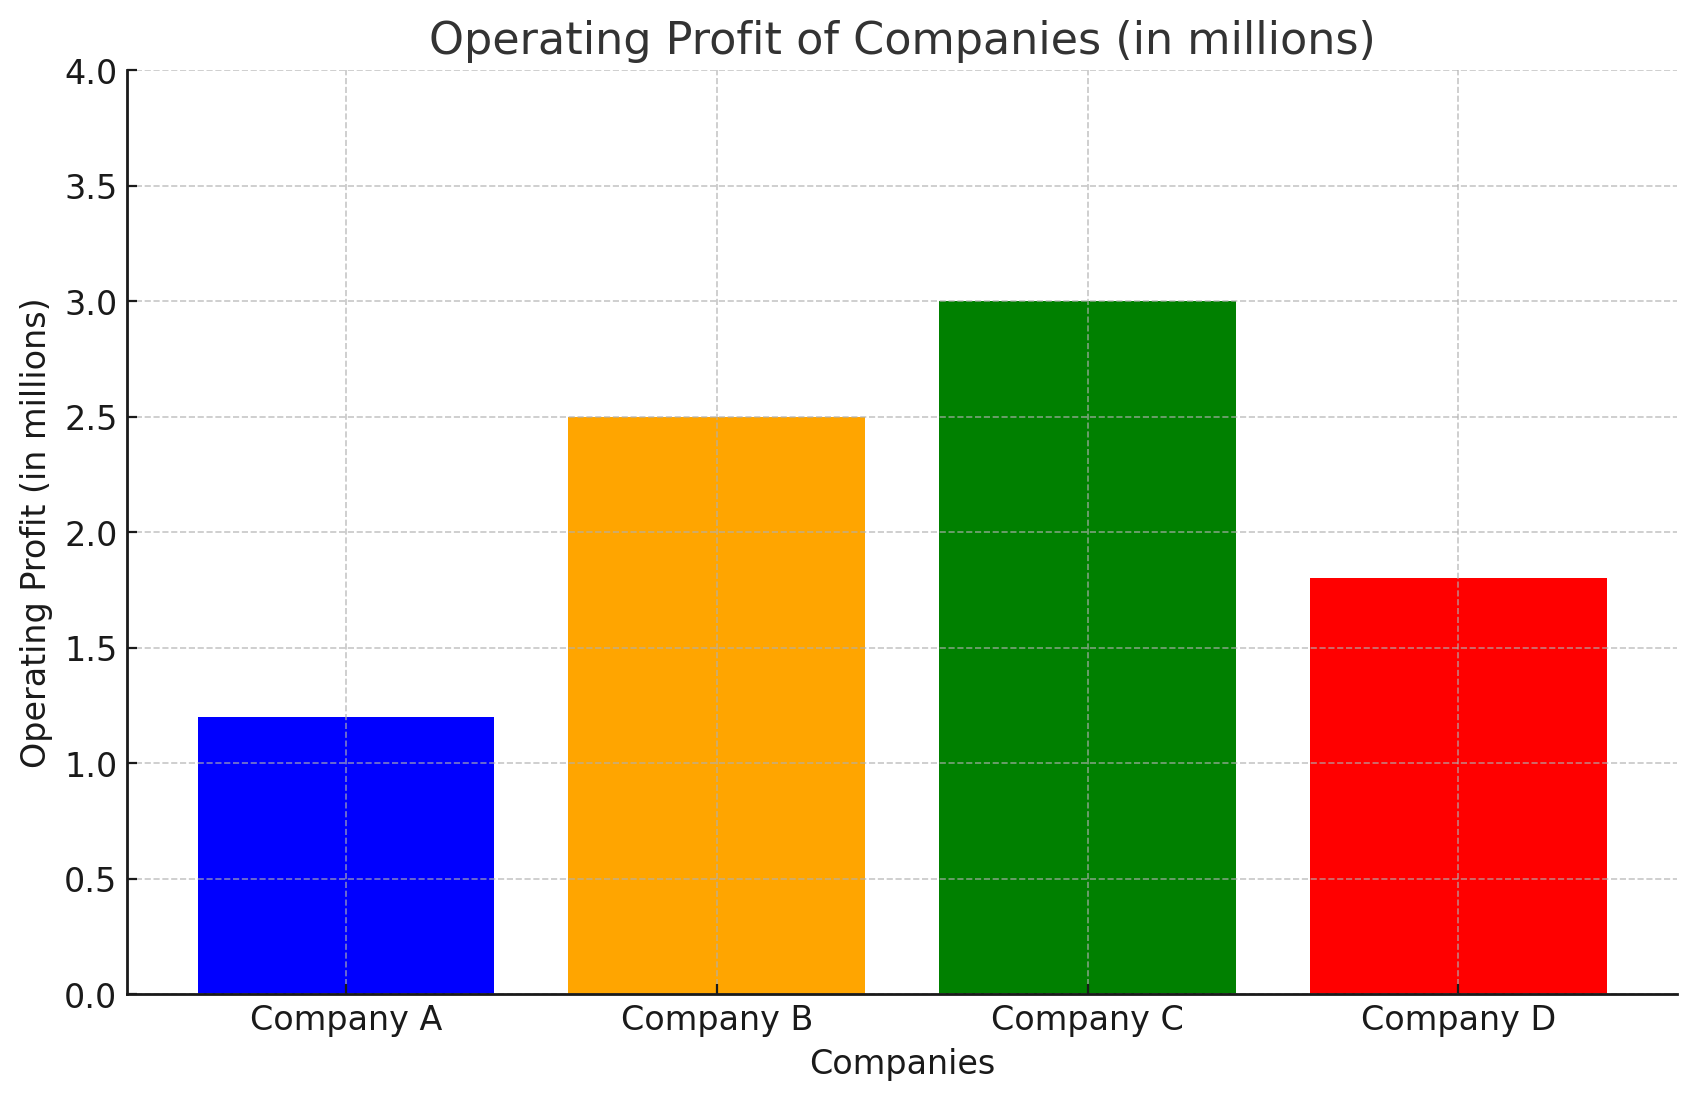

text: I have created the bar chart for the operating profit of the companies. You can download it using the link below:

[Download Operating Profit Chart](sandbox:/mnt/data/operating_profit_chart.png)


In [9]:
from IPython.display import Image, display
for c in json.loads(messages.to_json())["data"][0]["content"]:
    if c["type"]=="text":
        print(f'text: {c["text"]["value"]}')
    elif c["type"]=="image_file":
        file_id = c["image_file"]["file_id"]
        content = azure_openai_client.files.content(file_id=file_id)
        image= content.write_to_file(f"{file_id}.jpg")
        print(f'image_file: {file_id}')
        display(Image(filename=f"{file_id}.jpg"))

# Teardown

In [10]:
# delete thread. Beaware: it's not possible to retrieve the threads list as it is with AI Foundry Agents!
azure_openai_client.beta.threads.delete(thread_id=thread.id)

ThreadDeleted(id='thread_xn0We1zXXKLyhGlob99z4NwE', deleted=True, object='thread.deleted')

In [11]:
def list_assistants(aoc: AzureOpenAI, delete:bool=False):
    assistants = aoc.beta.assistants.list(limit=100).data

    i=0
    while len(assistants) > 0:
        for assistant in assistants:
            i=i+1
            if delete:
                print(f"Deleting assistant {i}: {assistant.id} ({assistant.name}) created at {datetime.fromtimestamp(assistant.created_at).strftime('%Y-%m-%d %H:%M:%S')}...")
                # client.beta.assistants.delete(assistant.id)
                aoc.beta.assistants.delete(assistant.id)
            else:
                print(f"Assistant {i}: {assistant.id} ({assistant.name}) created at {datetime.fromtimestamp(agent['created_at']).strftime('%Y-%m-%d %H:%M:%S')}...")

            assistants.remove(assistant)
            #agents = aoc.agents.list_agents(limit=100)['data']
    
    print (f"\n{i} assistants have been successfully processed.")


list_assistants(azure_openai_client, delete=True)

Deleting assistant 1: asst_EZsgJmfRePvHLySyshZGrxG0 (OpenAI Assistant #1) created at 2025-04-26 17:20:41...

1 assistants have been successfully processed.


# HIC SUNT LEONES